## 1. Use case
Daily historical sales data is provided by one of the company. The project is to forecast the total amount of products sold in every shop for the test set. 


## 2. Data Set

#### 1)File descriptions
sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.   
test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.   
sample_submission.csv - a sample submission file in the correct format.   
items.csv - supplemental information about the items/products.   
item_categories.csv  - supplemental information about the items categories.   
shops.csv- supplemental information about the shops.   

#### 2) Data fields
ID - an Id that represents a (Shop, Item) tuple within the test set   
shop_id - unique identifier of a shop   
item_id - unique identifier of a product   
item_category_id - unique identifier of item category   
item_cnt_day - number of products sold. You are predicting a monthly amount of this measure   
item_price - current price of an item   
date - date in format dd/mm/yyyy   
date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33   
item_name - name of item   
shop_name - name of shop   
item_category_name - name of item category   


In [36]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots



In [37]:
# Import data
sales=pd.read_csv("sales_train_v2.csv")
item_cat=pd.read_csv("item_categories.csv")
item=pd.read_csv("items.csv")
sub=pd.read_csv("sample_submission.csv")
shops=pd.read_csv("shops.csv")
test=pd.read_csv("test.csv")

Let's have a overview of the dataset first.

In [38]:
print(sales.shape)
sales.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [39]:
print(item_cat.shape)
item_cat.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [40]:
print(item.shape)
item.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [41]:
print(sub.shape)
sub.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [42]:
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [43]:
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [44]:
test.shop_id.unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

### 3. Data cleaning

####  Identify quality issues (e.g. missing values, wrong measurements, …)

In [45]:
# check missing values
sales.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

Great, no missing values.

In [46]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [47]:
# when data is very large, we can't find the unusual record one by one.
# so let's check the describe() first, and see if we can find some clue.
print(sales.describe())

       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03


As you see, the min of Item_cnt_day<0, that maybe because of sales return, but it's weird if item_price <0. So we just find that record and delete it.

In [48]:
# find the row which item_price <=0 
sales.loc[sales['item_price']<=0, :]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [49]:
# and delete it
sales=sales.drop(index=sales.loc[sales['item_price']<=0, :].index[0])

In [50]:
sales.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [84]:
# let's generate the monthly_sales as the project required
monthly_sales=sales.groupby(by=["shop_id","date_block_num"])[
    "item_cnt_day"].sum()
g=monthly_sales.reset_index()
# transe monthly sales from index to columns 
g=g.pivot(index='shop_id', columns='date_block_num', values='item_cnt_day')
g.head()

date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,
0,5578.0,6127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2947.0,3364.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1146.0,488.0,753.0,583.0,553.0,832.0,807.0,875.0,945.0,795.0,...,987.0,907.0,762.0,859.0,843.0,804.0,785.0,942.0,822.0,727.0
3,767.0,798.0,959.0,647.0,710.0,784.0,721.0,890.0,1026.0,793.0,...,977.0,738.0,741.0,740.0,731.0,672.0,535.0,666.0,745.0,613.0
4,2114.0,2025.0,2060.0,285.0,1211.0,1464.0,1378.0,1713.0,1536.0,1482.0,...,1188.0,980.0,978.0,899.0,893.0,793.0,842.0,947.0,732.0,831.0


In [90]:
# find shop_id we need to predict sales and merge with history sales
t=test.groupby("shop_id").count()

df = pd.merge(t, g, on=['shop_id'], how='left')

# fill na with 0
df = df.fillna(0)
# drop ID and item_id

df=df.drop(["ID", 'item_id'], axis=1)

df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,
2,1146.0,488.0,753.0,583.0,553.0,832.0,807.0,875.0,945.0,795.0,...,987.0,907.0,762.0,859.0,843.0,804.0,785.0,942.0,822.0,727.0
3,767.0,798.0,959.0,647.0,710.0,784.0,721.0,890.0,1026.0,793.0,...,977.0,738.0,741.0,740.0,731.0,672.0,535.0,666.0,745.0,613.0
4,2114.0,2025.0,2060.0,285.0,1211.0,1464.0,1378.0,1713.0,1536.0,1482.0,...,1188.0,980.0,978.0,899.0,893.0,793.0,842.0,947.0,732.0,831.0
5,0.0,877.0,1355.0,1008.0,1110.0,1393.0,1265.0,1510.0,1298.0,1267.0,...,1404.0,1101.0,1109.0,1054.0,1012.0,954.0,991.0,1294.0,1092.0,1052.0
6,3686.0,4007.0,4519.0,3168.0,3022.0,3847.0,3360.0,3702.0,4208.0,3675.0,...,2328.0,2329.0,1981.0,1998.0,1748.0,1539.0,1484.0,1575.0,1725.0,1802.0
7,2495.0,2513.0,2460.0,1540.0,1647.0,2085.0,2031.0,2397.0,2599.0,2236.0,...,2084.0,1847.0,1430.0,1340.0,1217.0,1235.0,1327.0,1409.0,1287.0,1212.0
10,935.0,1026.0,1017.0,756.0,683.0,764.0,800.0,755.0,1027.0,1013.0,...,628.0,0.0,565.0,594.0,466.0,441.0,449.0,442.0,519.0,428.0
12,842.0,1209.0,1419.0,1364.0,917.0,1710.0,723.0,1599.0,2032.0,1890.0,...,2832.0,1854.0,1886.0,3244.0,3949.0,1830.0,1554.0,1471.0,5215.0,4181.0
14,1777.0,1795.0,1893.0,1247.0,1489.0,1863.0,1709.0,2216.0,796.0,1534.0,...,1233.0,1007.0,1002.0,1055.0,933.0,1019.0,954.0,1061.0,1094.0,1002.0


Now, let's do some basic data exploration.

### 4. Data Exploration

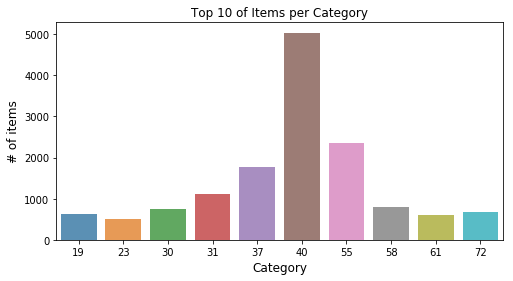

In [14]:
# number of items per category 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Top 10 of Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

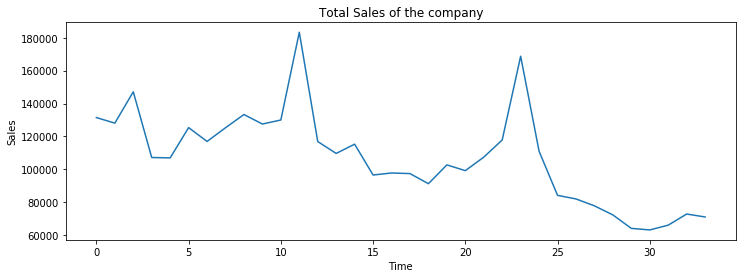

In [15]:
# the total sales per month for the company
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(12,4))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

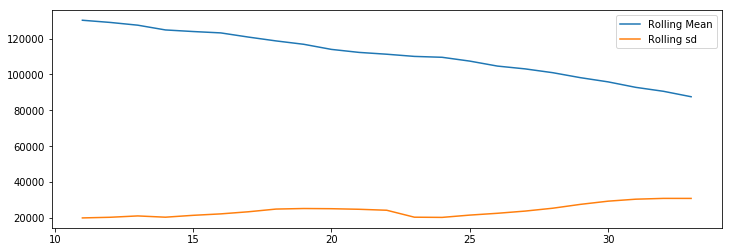

In [16]:
plt.figure(figsize=(12,4))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend()

From the plot, we can see that peak sales appeares one month of year and a decreasing Trend. Abviously sales are relevant to time. So let's try Time series model.

### 5. Model Training
##### 1) Random Forest


In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [98]:
# Extract the training and test data
data = df.values
X = data[:, 1:]  # all rows, no label
y = data[:, 0]  # all rows, label only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [99]:
# Establish model
model = RandomForestRegressor(n_jobs=-1)

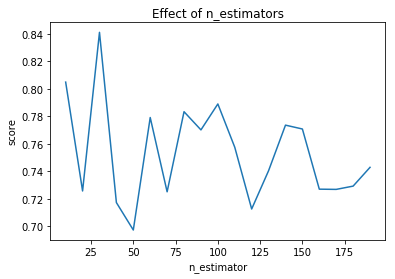

In [100]:
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [102]:
pip install keras


The following command must be run outside of the IPython shell:

    $ pip install keras

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [101]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

ModuleNotFoundError: No module named 'keras'

In [ ]:

model = Sequential()
model.add(LSTM(units=64, input_shape=(33, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train, batch_size=4096, epochs=10)

In [ ]:
splits = df.randomSplit([0.8, 0.2])
df_train = splits[0]
df_test = splits[1]

In [93]:
model = RandomForestRegressor(n_estimators=1000,
                               n_jobs=-1,
                                random_state=0)
steps_1 = [('1_step',
              ToSupervised('df','shop_id',1)),
           ('1_step_diff',
              ToSupervisedDiff('0',
                       'Product_Code',1,dropna=True)),
           ('predic_1',
              TimeSeriesRegressor(model=model,cv=kf))]
super_1_p = Pipeline(steps_1).fit(df)
Model_1_Error = super_1_p.score(df)

NameError: name 'ToSupervised' is not defined

In [36]:
# let's generate the monthly_sales as the project required
monthly_sales=sales.groupby(["date_block_num","shop_id"])[
    "item_cnt_day"].sum()
monthly_sales.head()

date_block_num  shop_id
0               0          5578.0
                1          2947.0
                2          1146.0
                3           767.0
                4          2114.0
Name: item_cnt_day, dtype: float64

In [51]:
monthly_sales.columns

MultiIndex(levels=[['date', 'item_price', 'item_cnt_day'], ['max', 'mean', 'min', 'sum']],
           labels=[[0, 0, 1, 2], [2, 0, 1, 3]])

In [30]:
print(monthly_sales.shape)

(1609124, 4)


In [29]:
print(monthly_sales.describe())

         item_price  item_cnt_day
               mean           sum
count  1.609124e+06  1.609124e+06
mean   7.908847e+02  2.267200e+00
std    1.551605e+03  8.649882e+00
min    9.000000e-02 -2.200000e+01
25%    1.990000e+02  1.000000e+00
50%    3.990000e+02  1.000000e+00
75%    8.985000e+02  2.000000e+00
max    3.079800e+05  2.253000e+03


In [55]:
monthly_sales.loc[monthly_sales[['item_cnt_day','sum']<0, :].shape

SyntaxError: unexpected EOF while parsing (<ipython-input-55-e45d0dedd400>, line 1)

### 3. Initial Data Exploration

       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None
